In [1]:
from monai import transforms
from scripts.data import Centre2DDataset, load_2D_data
from scripts.utils import load_metadata
import matplotlib.pyplot as plt
from math import pi


def prepare_ax(ax, image, title, cmap=None):
    ax.imshow(image, cmap=cmap)
    ax.set_title(title)
    ax.axis("off")
    return ax


def plot_augmentations(images, labels, transform, title="Augmentations",n_examples=4):
    fig, ax = plt.subplots(2, 2*n_examples, figsize=(10*n_examples, 10))

    for i in range(2, n_examples+2):
        image = images[i]
        label = labels[i]
        fn_keys = {"img": image, "seg": label}

        transformed_keys = transform(fn_keys)
        ax[0, 0+(i-2)] = prepare_ax(ax[0, 2*(i-2)], image[0], title="Real image", cmap="gray")
        ax[0, 1+(i-2)] = prepare_ax(ax[0, 1+2*(i-2)] , label[0], title="Real segmentation")
        ax[1, 0+(i-2)] = prepare_ax(ax[1, 2*(i-2)] , transformed_keys["img"][0], title="Augmented image", cmap="gray")
        ax[1, 1+(i-2)] = prepare_ax(ax[1, 1+2*(i-2)] , transformed_keys["seg"][0], title="Augmented segmentation")

    # add a title
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

%load_ext autoreload
%autoreload 2

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
metadata = load_metadata()
load_transform = transforms.ScaleIntensity(minv=0.0, maxv=1.0, channel_wise=True)
images, labels, ps = load_2D_data(centre=1, metadata=metadata, transform=load_transform)

Loading Images for centre:  1
Loading Labels for centre:  1


  0%|          | 0/89 [00:00<?, ?File/s]

100%|██████████| 89/89 [00:01<00:00, 60.62File/s]


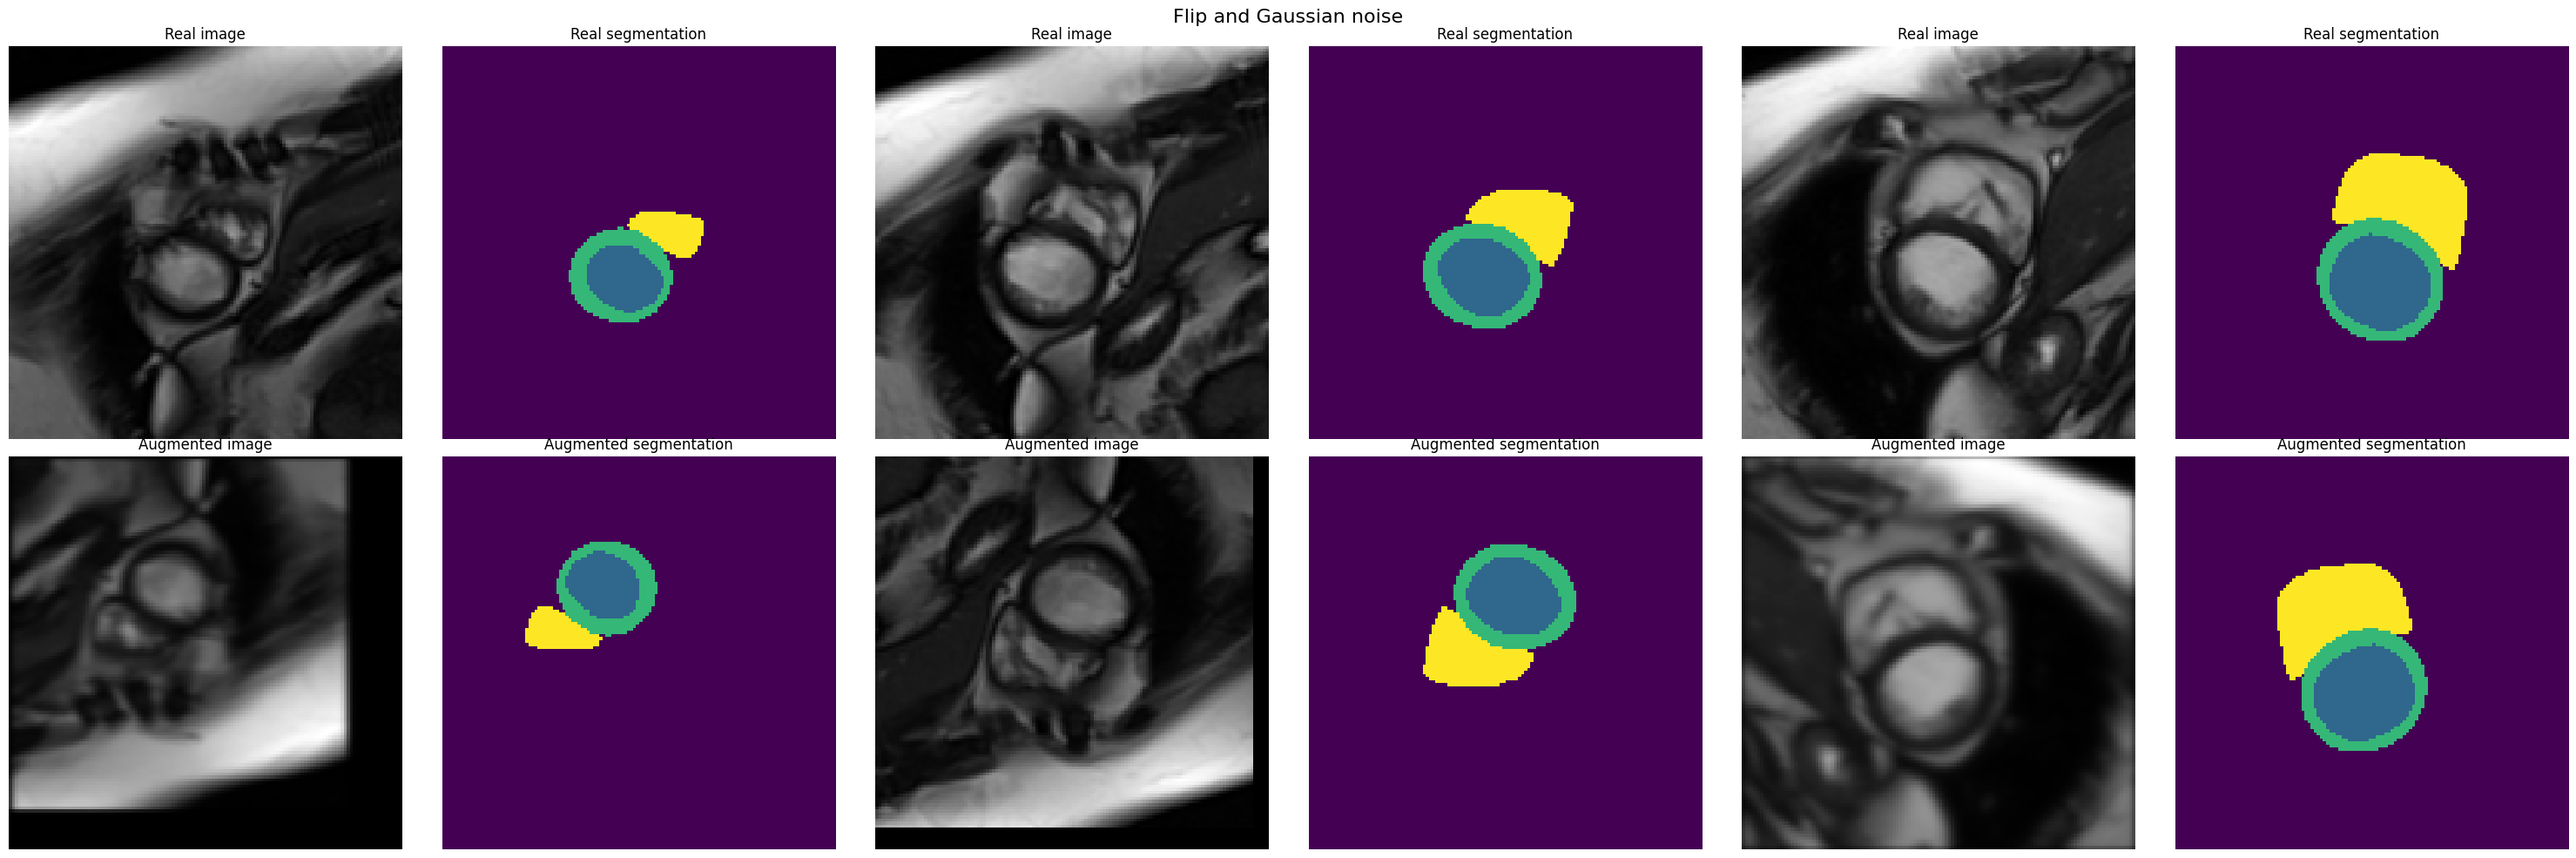

In [49]:

transform = transforms.Compose(
    [
        transforms.RandFlipd(keys=("img", "seg"), prob=0.5, spatial_axis=[1]),
        transforms.RandFlipd(keys=("img", "seg"), prob=0.5, spatial_axis=[0]),

        transforms.RandAffined(
            keys=["img", "seg"],
            padding_mode="constant",
            translate_range=(20, 20),
            mode=[5, "nearest"],
            prob=0.7,
        ),
        transforms.RandZoomd(
            keys=["img", "seg"],
            min_zoom=0.9,
            max_zoom=1.1,
            prob=0.5,
            mode="nearest-exact",
            padding_mode="constant",
        ),
        
        transforms.OneOf([
            transforms.RandGibbsNoised(keys = ("img", ) , prob=1, alpha=(0., 0.5)),
            transforms.RandGaussianSmoothd(keys= ("img"), prob=1, sigma_x=(0.25, 1.5), sigma_y=(0.25, 1.5)),
            transforms.RandBiasFieldd(keys=("img",), prob=1, coeff_range=(0.1, 0.2)),
            ])
    ]
)

plot_augmentations(images, labels, transform=transform, title="Flip and Gaussian noise",n_examples=3)

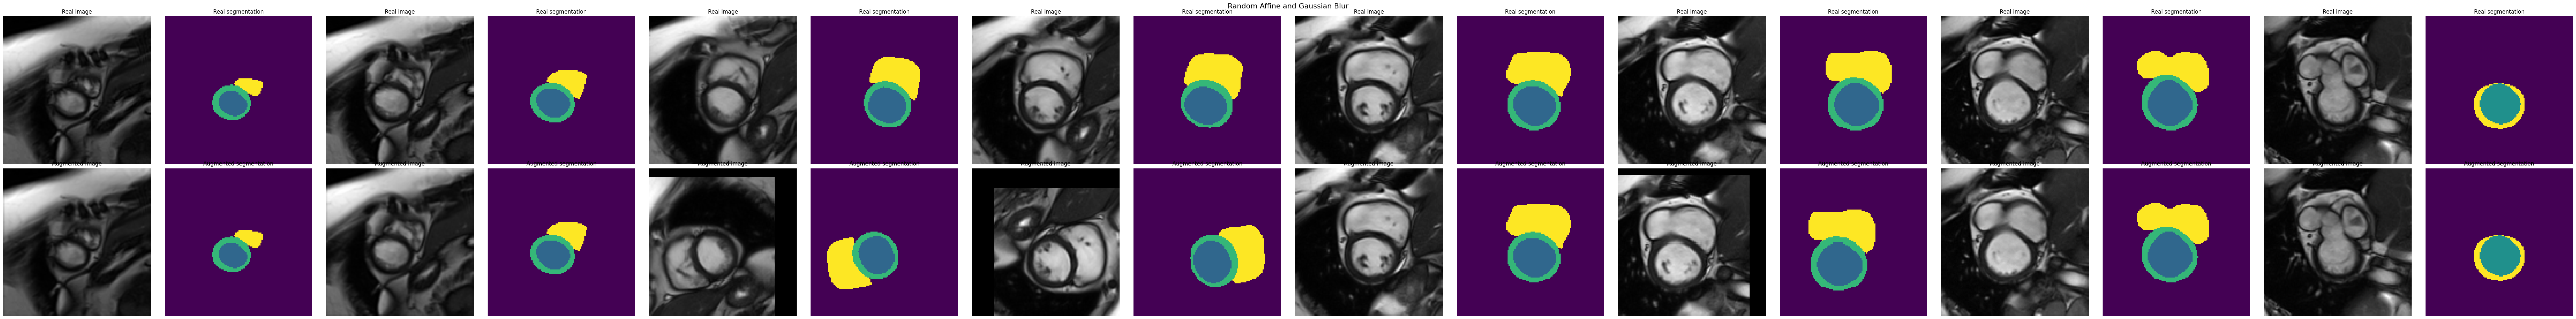

In [23]:
transform = transforms.Compose(
    [
        transforms.OneOf(
            [
                transforms.Compose(
                    [
                        transforms.SomeOf(
                            [
                                transforms.Rotated(
                                    keys=["img", "seg"], angle=pi / 2, mode="nearest"
                                ),
                                transforms.Rotated(
                                    keys=["img", "seg"], angle=pi, mode="nearest"
                                ),
                                transforms.RandFlipd(
                                    keys=("img", "seg"), prob=1, spatial_axis=[1]
                                ),
                                transforms.RandFlipd(
                                    keys=("img", "seg"), prob=1, spatial_axis=[0]
                                ),
                            ],
                            num_transforms=[0, 4],
                        ),
                        transforms.RandAffined(
                            keys=["img", "seg"],
                            padding_mode="constant",
                            translate_range=(20, 20),
                            mode=[5, "nearest"],
                            prob=0.7,
                        ),
                        transforms.RandZoomd(
                            keys=["img", "seg"],
                            min_zoom=0.9,
                            max_zoom=1.1,
                            prob=0.5,
                            mode="nearest-exact",
                            padding_mode="constant",
                        ),
                    ]
                ),


                transforms.SomeOf(
                    [
                        transforms.RandHistogramShiftd(
                            keys=("img",), prob=1, num_control_points=10
                        ),
                        transforms.SomeOf(
                            [
                                transforms.RandGaussianNoised(
                                    keys=("img",), prob=1, mean=0.0, std=0.05
                                ),
                                transforms.RandGaussianNoised(
                                    keys=("img",), prob=1, mean=0.2, std=0.05
                                ),
                                # transforms.RandGaussianNoised(keys=("img",), prob=1, mean=0.8, std=0.1),
                            ],
                            num_transforms=[0, 1],
                        ),
                        transforms.RandShiftIntensityd(keys=("img",), prob=1, offsets=(0, 0.3)),
                        transforms.RandGaussianSmoothd(
                            keys=("img",), prob=0.7, sigma_x=(0.3, 0.5), sigma_y=(0.3, 0.5)
                        ),
                        transforms.RandBiasFieldd(
                            keys=("img",), prob=1, coeff_range=(0.1, 0.2)
                        ),
                    ], num_transforms=[1, 2]
                ),

            ]
        )
    ]
)

plot_augmentations(images, labels, transform=transform, title="Random Affine and Gaussian Blur", n_examples=8)

**Remarks**
* nearerst not smooth
* bilinear too blurry
* padding mode reflect is better
* always leave scale, no need for a seperate transform

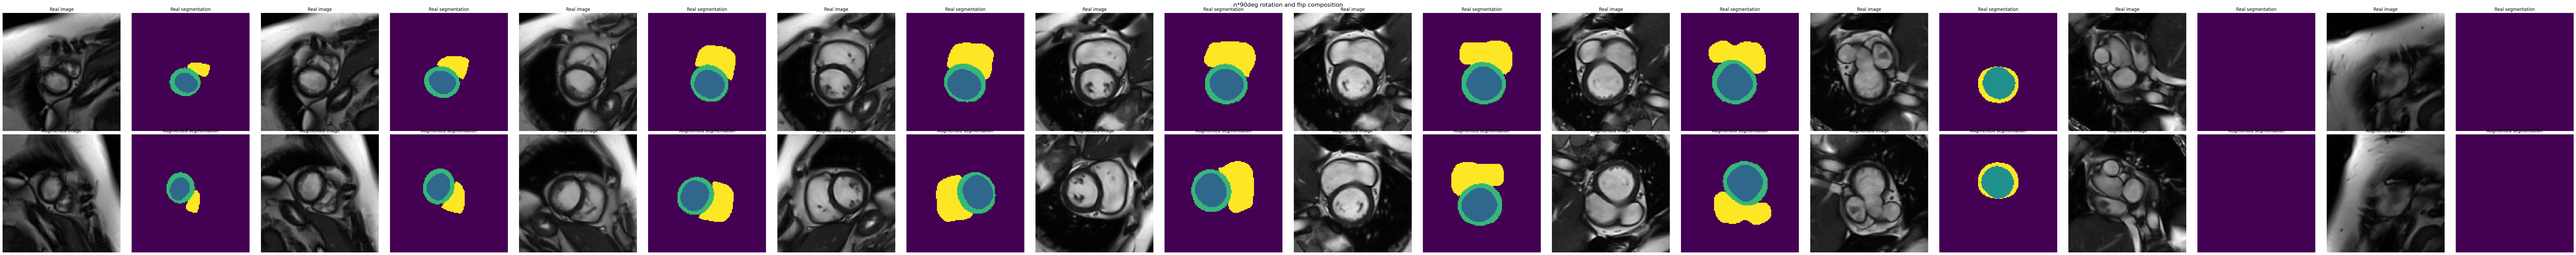

In [82]:
transform = transforms.Compose(
    [        
        transforms.SomeOf(
            [
                transforms.Rotated(keys=["img", "seg"], angle=pi/2, mode="nearest"),
                transforms.Rotated(keys=["img", "seg"], angle=pi, mode="nearest"),                
               
                transforms.RandFlipd(keys=("img", "seg"), prob=0.5, spatial_axis=[1]),
                transforms.RandFlipd(keys=("img", "seg"), prob=0.5, spatial_axis=[0]),
            ], num_transforms=[1, 4]),
    ]
)

plot_augmentations(images, labels, transform=transform, title="n*90deg rotation and flip composition", n_examples=10)

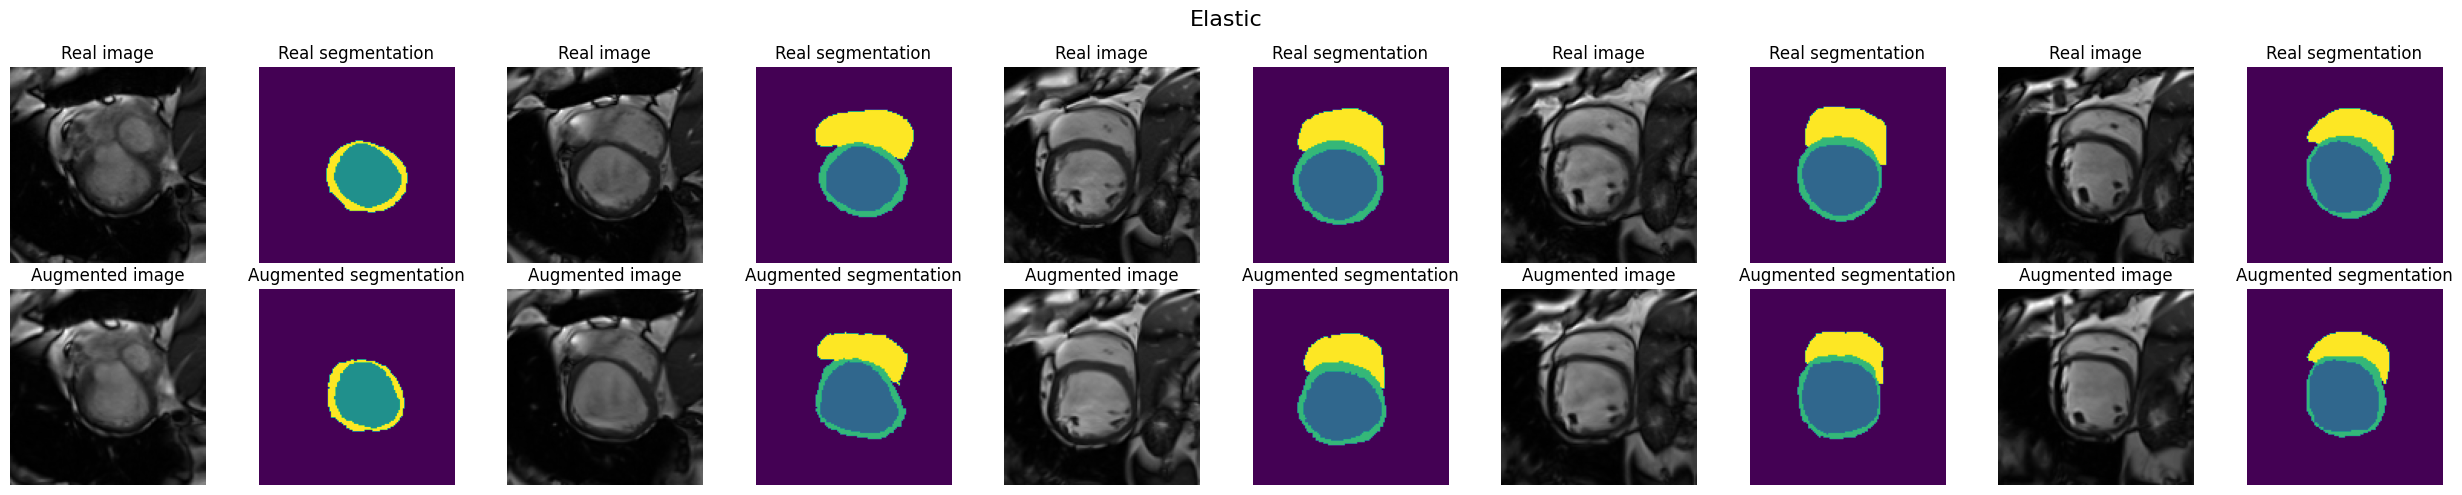

In [93]:
transform = transforms.Compose(
    [        
        transforms.Rand2DElasticd(
            keys=["img", "seg"], prob=1, padding_mode="reflection", magnitude_range=(0, 3), spacing=45, mode=("bilinear", "nearest")),
    ]
)

plot_augmentations(images, labels, transform=transform, title="Elastic" ,n_examples=5)

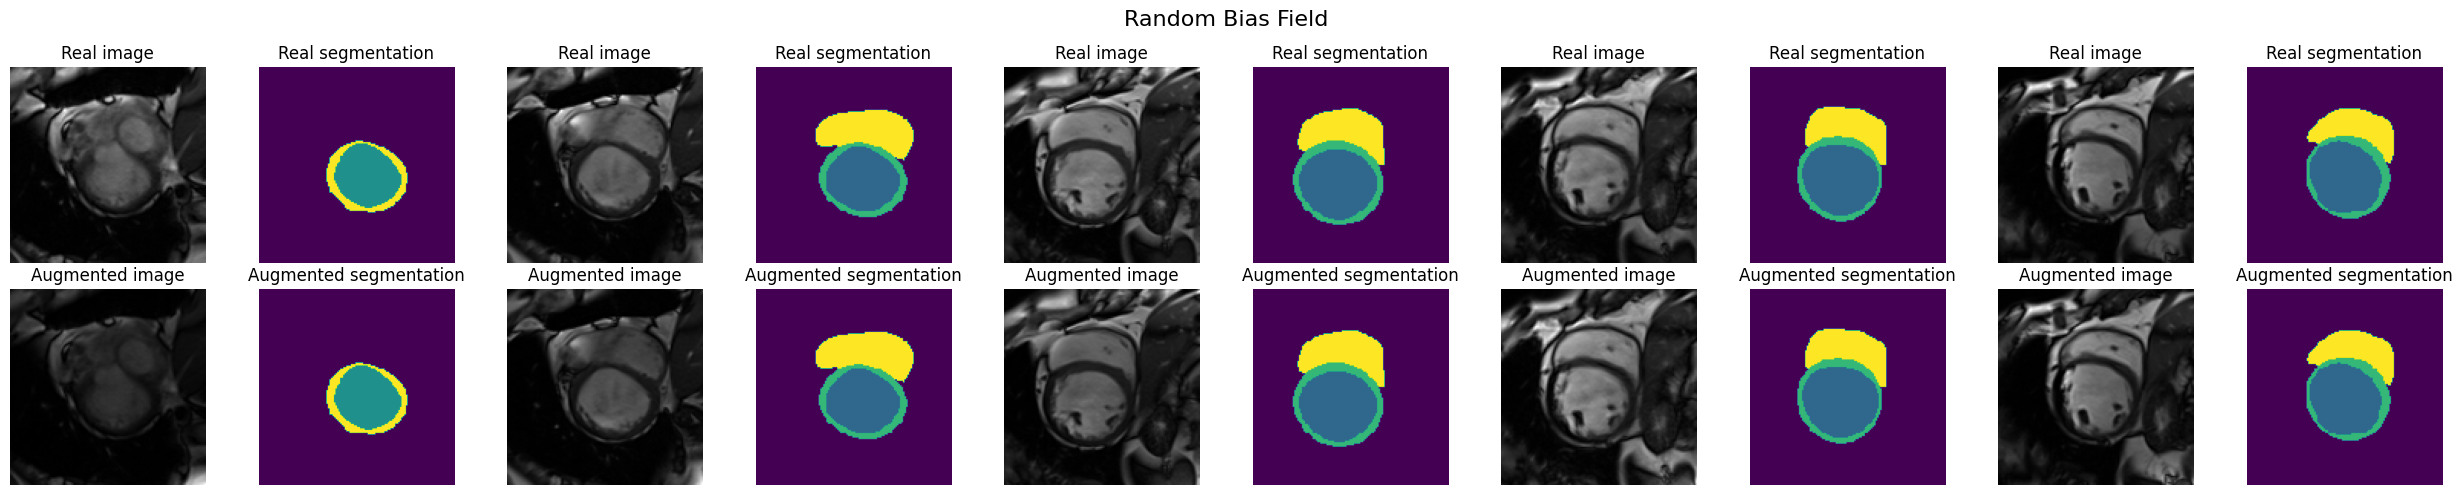

In [103]:
transform = transforms.Compose(
    [        
        transforms.RandBiasFieldd(
            keys=("img", ), prob=1, coeff_range=(0., 0.3))
    ]
)

plot_augmentations(images, labels, transform=transform, title="Random Bias Field" ,n_examples=5)

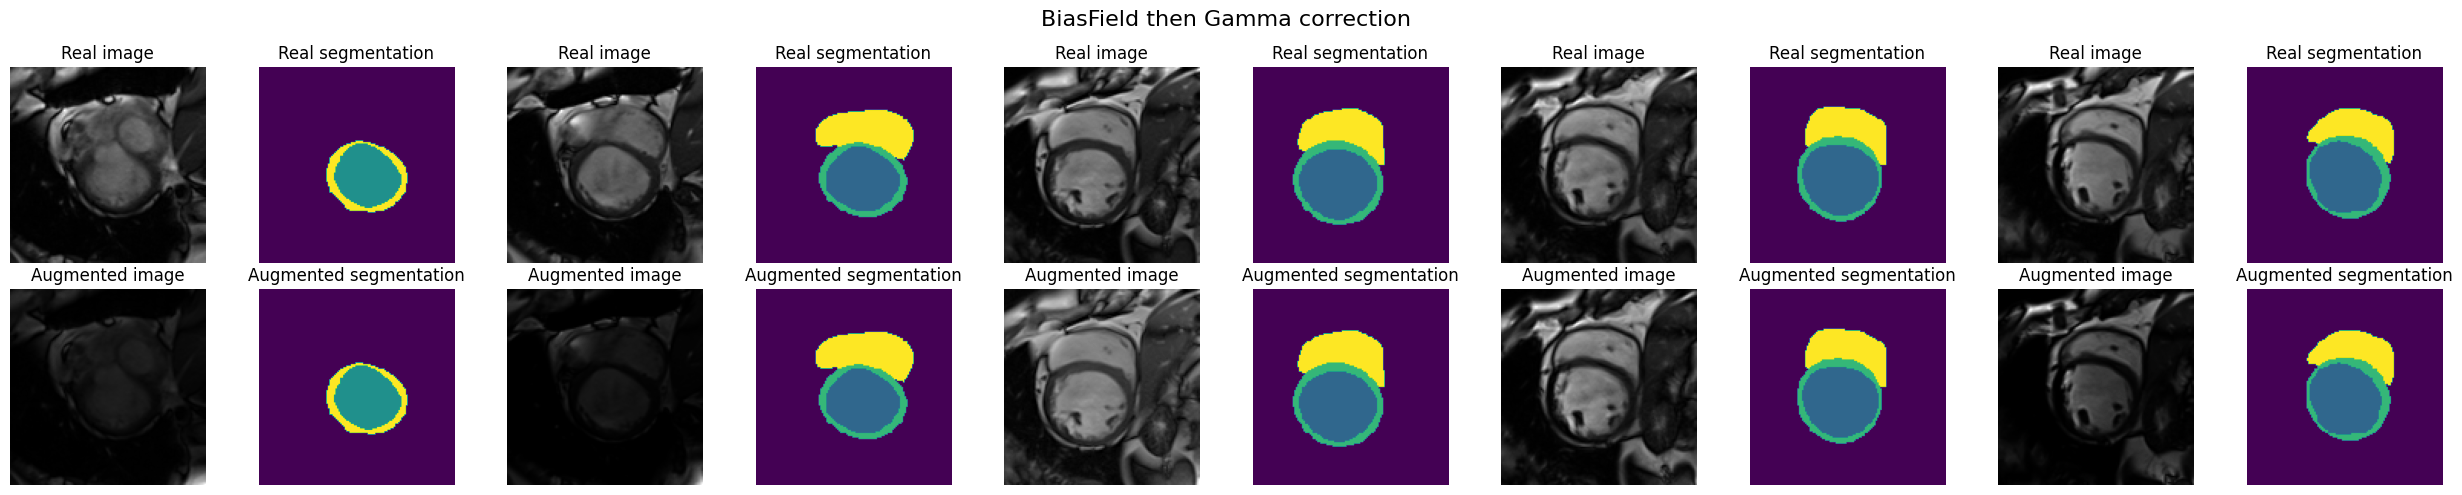

In [133]:
transform = transforms.Compose(
    [
        transforms.RandBiasFieldd(
            keys=("img", ), prob=1, coeff_range=(0., 0.3)),
        transforms.RandAdjustContrastd(
            keys=("img", ), prob=1, gamma=(0.7, 1.5)),
    ]
)

plot_augmentations(images, labels, transform=transform, title="BiasField then Gamma correction" ,n_examples=5)

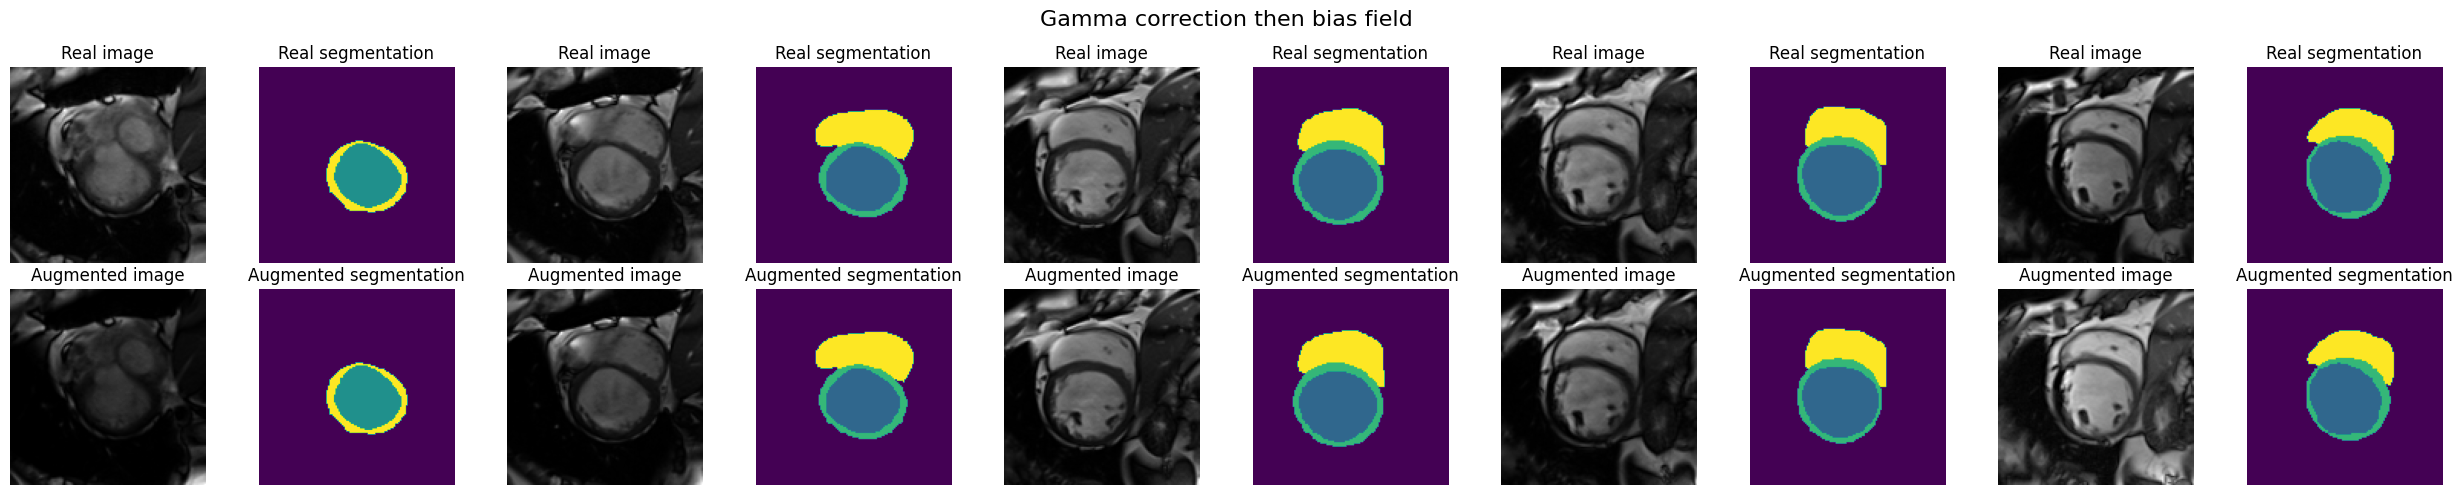

In [134]:
transform = transforms.Compose(
    [
        transforms.RandAdjustContrastd(
            keys=("img", ), prob=1, gamma=(0.7, 1.5)),
        transforms.RandBiasFieldd(
            keys=("img", ), prob=1, coeff_range=(0., 0.3)),

    ]
)

plot_augmentations(images, labels, transform=transform, title="Gamma correction then bias field" ,n_examples=5)

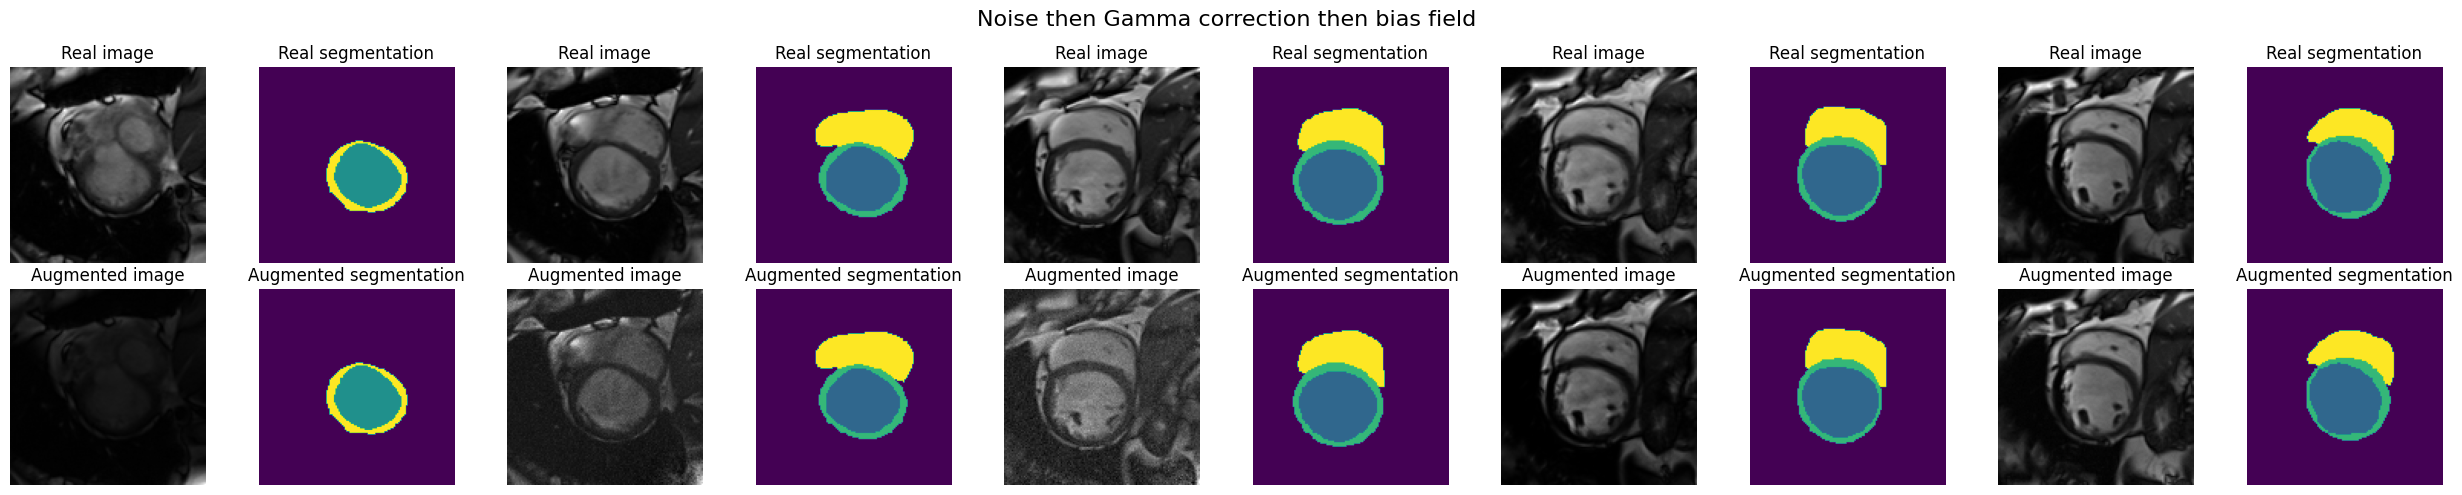

In [135]:
transform = transforms.Compose(
    [
        transforms.RandGaussianNoised(keys=("img", ), prob=1, mean=0., std=0.05),
        transforms.RandAdjustContrastd(
            keys=("img", ), prob=1, gamma=(0.7, 1.5)),
        transforms.RandBiasFieldd(
            keys=("img", ), prob=1, coeff_range=(0., 0.3)),

    ]
)

plot_augmentations(images, labels, transform=transform, title="Noise then Gamma correction then bias field" ,n_examples=5)

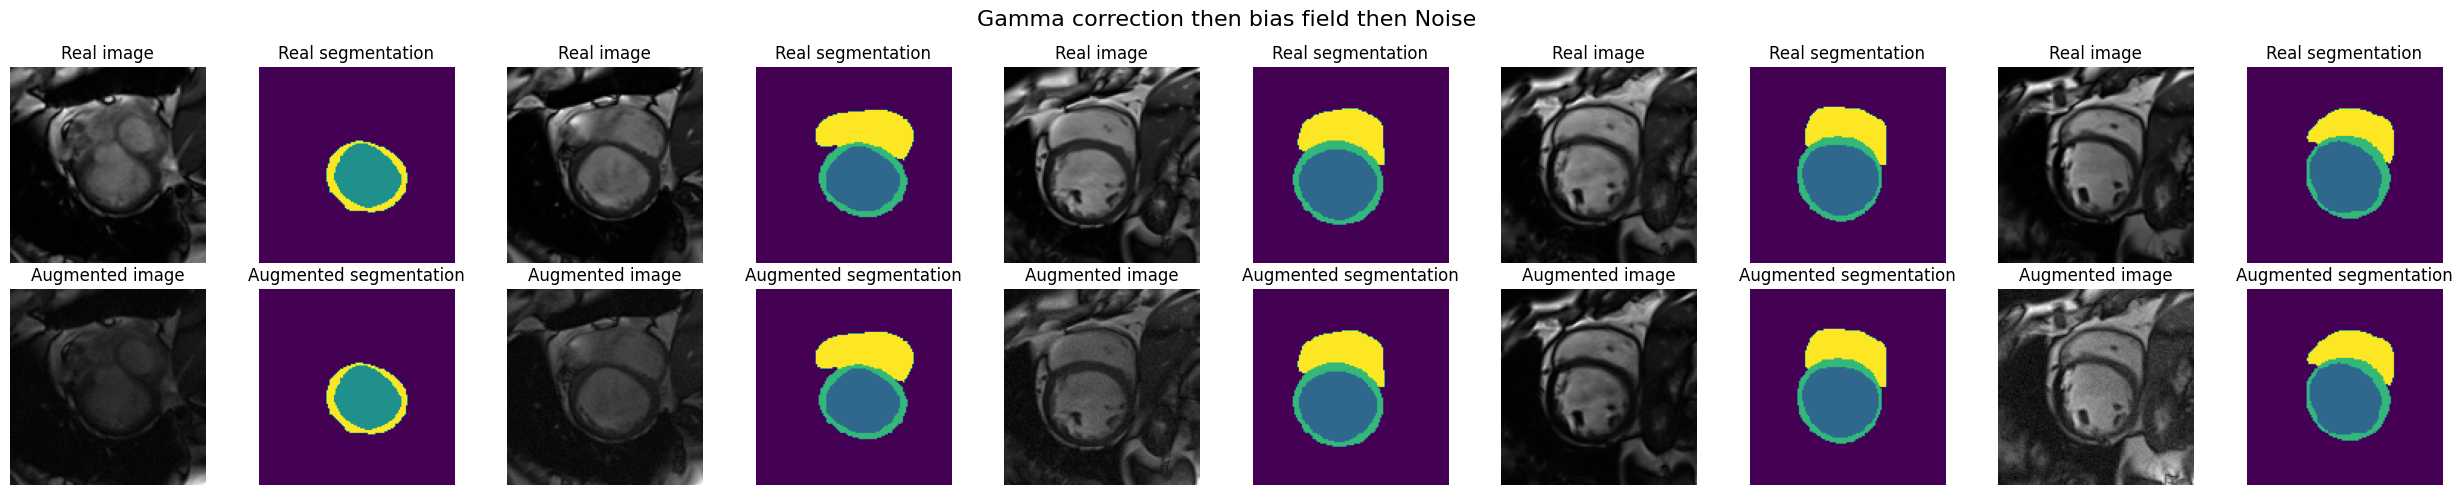

In [137]:
transform = transforms.Compose(
    [
        transforms.RandAdjustContrastd(
            keys=("img", ), prob=1, gamma=(0.7, 1.5)),
        transforms.RandBiasFieldd(
            keys=("img", ), prob=1, coeff_range=(0., 0.3)),
        transforms.RandGaussianNoised(keys=("img", ), prob=1, mean=0., std=0.05),

    ]
)

plot_augmentations(images, labels, transform=transform, title="Gamma correction then bias field then Noise" ,n_examples=5)

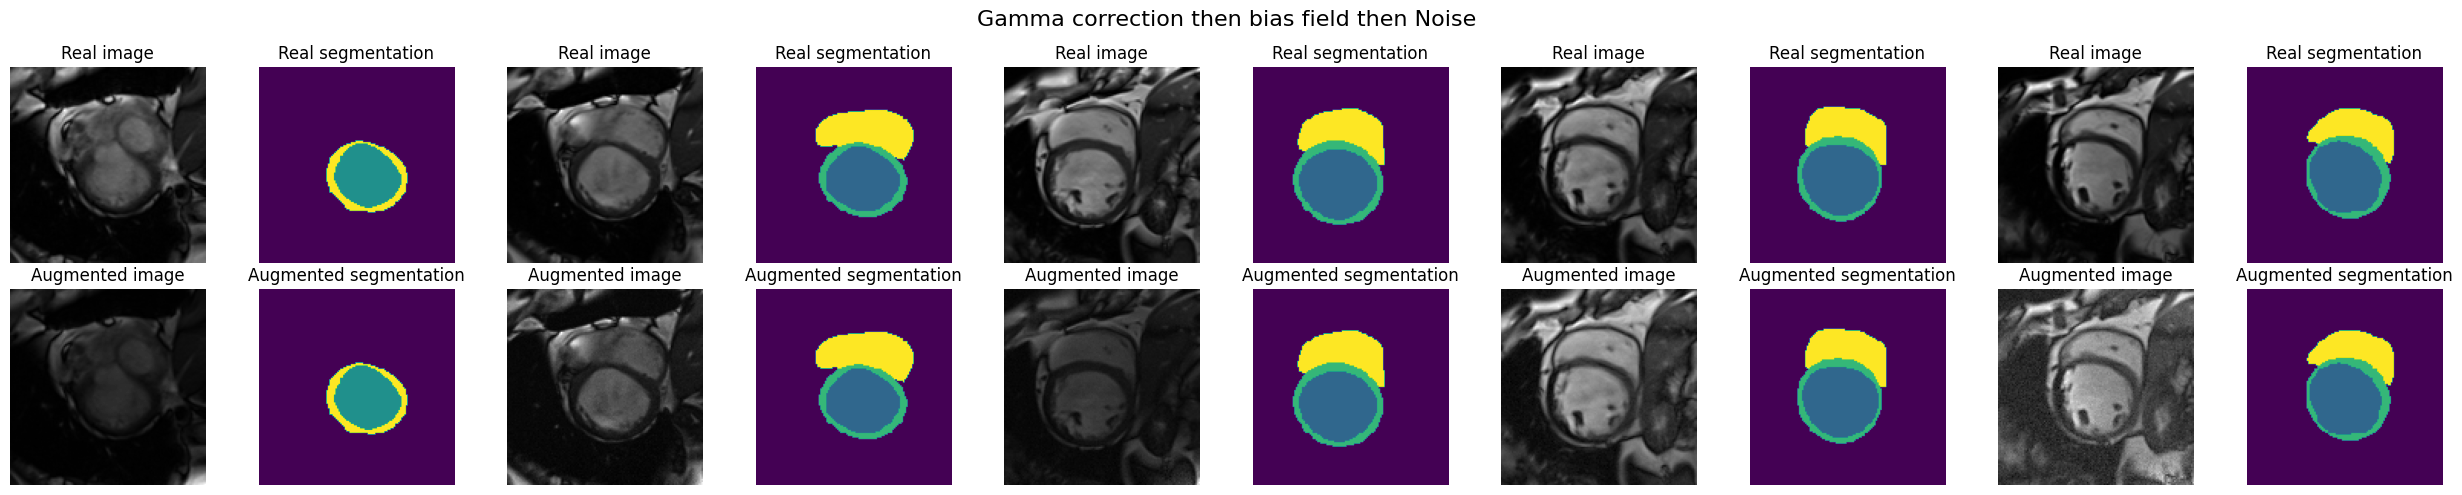

In [37]:
intensity_keys = ("img", )
transform = transforms.Compose(
    [
        transforms.RandGaussianNoised(
            keys=intensity_keys, prob=0.9, mean=0, std=0.03),

        transforms.RandAdjustContrastd(
            keys=intensity_keys, prob=0.8, gamma=(0.7, 1.4)),

        transforms.RandBiasFieldd(
            keys=intensity_keys, prob=0.8, coeff_range=(0., 0.3)),10

    ]
)

plot_augmentations(images, labels, transform=transform, title="Gamma correction then bias field then Noise" ,n_examples=5)